<a href="https://www.kaggle.com/code/subratasubha/boot-or-sneaker-classifier?scriptVersionId=125108295" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "boots photos"
1. Use DuckDuckGo to search for images of "sneakers photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

In [2]:
!pip install duckduckgo_search

In [3]:
import duckduckgo_search
from fastcore.all import *

## Fetch images of boots and sneakers

In [4]:
# function to fetch images from duckduck_go
def fetch_images(query,max_results = 100):
    print(f"Fetching: {query} ---> image search...")
    return L(duckduckgo_search.ddg_images(keywords = query,max_results=max_results)).itemgot("image")

In [5]:
# fetch list of images of boots 
boots_urls_list = fetch_images("boot")       # return type: fastcore.foundation.L
print(boots_urls_list[0])

# fetch list images of sneakers
sneakers_urls_list = fetch_images("sneaker") # return type: fastcore.foundation.L
print(sneakers_urls_list[0])

Fetching: boot ---> image search...
https://sep.yimg.com/ay/yhst-48446621305942/danner-usmc-rat-hot-military-boots-15670x-30.jpg
Fetching: sneaker ---> image search...
https://image.peltzshoes.com/images/products/1_757095_ZM.jpg


## Download images of boots and sneakers

In [6]:
import fastdownload
from fastai.vision.all import *

Fetching: boot ---> image search...


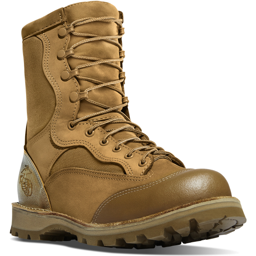

In [7]:
# fetch_images: user defined function
fastdownload.download_url(fetch_images('boot', max_results=1)[0], 'boot.jpg', show_progress=False)
Image.open('boot.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "boots" and "sneakers" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [8]:
from time import sleep
searches = ('boots','sneakers')
path = Path('boots_or_sneeakers')

for index, query in enumerate(searches):
    dest = (path/query)
    print(f"dest{index}: {dest}")
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=fetch_images(query))                   # query1: "boots/sneakers"
    sleep(10)  # Pause between searches to avoid over-loading server  
    download_images(dest, urls=fetch_images(f'low top {query}'))      # query2: "low top boots/sneakers"
    sleep(10)
    download_images(dest, urls=fetch_images(f'mid top {query}'))      # query3: "mid top boots/sneakers"
    sleep(10)
    download_images(dest, urls=fetch_images(f'high top {query}'))     # query4: "high top boots/sneakers"
    sleep(10)
    resize_images(path/query, max_size=400, dest=path/query)

dest0: boots_or_sneeakers/boots
Fetching: boots ---> image search...
Fetching: low top boots ---> image search...
Fetching: mid top boots ---> image search...
Fetching: high top boots ---> image search...
dest1: boots_or_sneeakers/sneakers
Fetching: sneakers ---> image search...
Fetching: low top sneakers ---> image search...
Fetching: mid top sneakers ---> image search...
Fetching: high top sneakers ---> image search...


## Model training
Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [9]:
print(path)
print(len(get_image_files(path)))
# Help on function get_image_files in module fastai.data.transforms:
get_image_files(path)

boots_or_sneeakers
758


(#758) [Path('boots_or_sneeakers/sneakers/e1288716-7f8f-4a76-8f91-d6713c7d5d91.jpg'),Path('boots_or_sneeakers/sneakers/2e4643ac-1e1d-47e9-8516-74f808ac0d6f.jpeg'),Path('boots_or_sneeakers/sneakers/4dc98bd2-0658-464c-9952-a5fa8c642d2c.jpeg'),Path('boots_or_sneeakers/sneakers/cd578fc2-ebdd-448a-bc3d-4873b93f615c.jpg'),Path('boots_or_sneeakers/sneakers/9fd3906a-a958-44e4-9303-b16786924eb6.jpg'),Path('boots_or_sneeakers/sneakers/82dd04c6-1281-479e-b543-7b90c6b711d0.jpg'),Path('boots_or_sneeakers/sneakers/27923fa1-1f72-4a1e-898c-78998738dbfb.jpeg'),Path('boots_or_sneeakers/sneakers/e70b5509-bebd-4d26-b986-5296c18a697b.jpg'),Path('boots_or_sneeakers/sneakers/4577b4ff-b43d-4f0b-81f2-197c8831efa6.jpeg'),Path('boots_or_sneeakers/sneakers/c6aeba72-cc02-4b56-9778-91a5df54c5ce.jpeg')...]

In [10]:
# Find images in `fns` that can't be opened
failed = verify_images(get_image_files(path))

# Path.unlink: (1). Remove this file or link. (2). If the path is a directory, use rmdir() instead.
failed.map(Path.unlink)
len(failed)

19

To train a model, we'll need **`DataLoaders`**, which is an object that contains a *`training set`* (the images used to create a model) and a *`validation set`* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a **`DataBlock`**, and view sample images from it:

<class 'fastai.data.core.DataLoaders'>


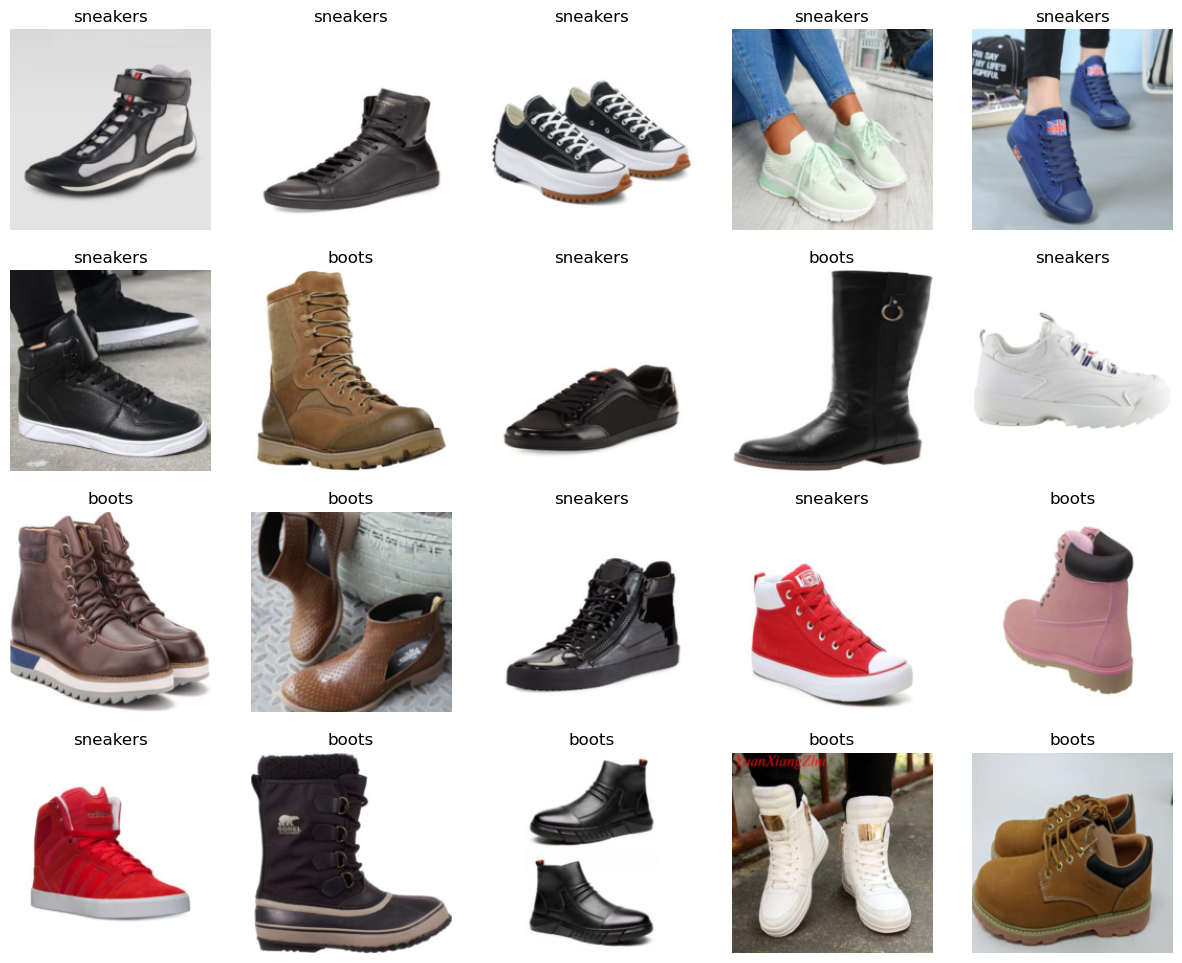

In [11]:
# creating dataloaders(dls)
dls = DataBlock(
    # blocks = (inputType, outputType)
    blocks=(ImageBlock, CategoryBlock),
    #list of images for training
    get_items=get_image_files, 
    # data splitting, "valid_pct=0.2" implies 20% of the data is kept for validation
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

print(type(dls))
dls.show_batch(max_n=20)

Here what each of the `DataBlock` parameters means:

```python
    blocks=(ImageBlock, CategoryBlock),
```

The inputs to our model are images, and the outputs are categories (in this case, "boots" or "sneakers").

```python
    get_items=get_image_files, 
```

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

```python
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
```

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

```python
    get_y=parent_label,
```

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *boots* or *sneakers*).

```python
    item_tfms=[Resize(192, method='squish')]
```

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

### Training

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.704870,0.468739,0.142857,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.317411,0.410121,0.129252,00:45
1,0.226165,0.315441,0.095238,00:45
2,0.173922,0.324858,0.102041,00:45
3,0.133507,0.242817,0.108844,00:45
4,0.099283,0.251998,0.095238,00:44
5,0.089794,0.293381,0.095238,00:44
6,0.069812,0.330028,0.088435,00:44
7,0.056284,0.299445,0.068027,00:44
8,0.046956,0.293888,0.061224,00:45
9,0.040528,0.305817,0.068027,00:44


### Downloading images for prediction

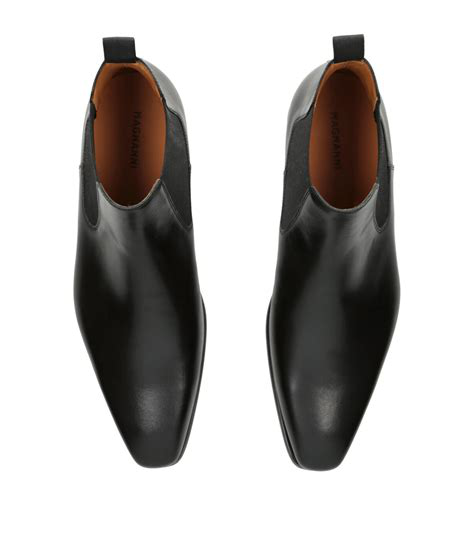

In [13]:
dest1 = 'boot1.jpg'
boot_img_url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse3.mm.bing.net%2Fth%3Fid%3DOIF.BgcO39zjCvNQXxubyJhjVg%26pid%3DApi&f=1&ipt=e84969dd48c1b56344d1d7afd5256b86126eeb9b167c6b0849c30b5dc2e806b6&ipo=images"
fastdownload.download_url(boot_img_url, dest1, show_progress=False)

dest2 = "sneaker.jpg"
sneaker_url = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse3.mm.bing.net%2Fth%3Fid%3DOIP.j-jzqYu4ttUsB2vtsH9doAHaHa%26pid%3DApi&f=1&ipt=5e158f3f466a9c460c9f03ed68c8401f1de841ede0ff0333807b528b3b894b60&ipo=images"
fastdownload.download_url(sneaker_url, dest2, show_progress=False)

# view image
PILImage.create(dest1)

In [14]:
# whether or not it's a bird: as a string(is_bird), as an integer (_), as probability (probs)
is_boot_or_sneaker,_,probs = learn.predict(PILImage.create(dest1))
print(f"This is a: {is_boot_or_sneaker}.")
print(f"Probability it's a boot {probs[0]:.4f}")

This is a: boots.
Probability it's a boot 1.0000


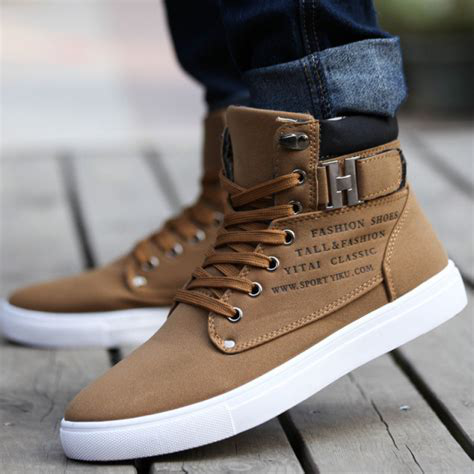

In [15]:
# view image
PILImage.create(dest2)

In [16]:
# whether or not it's a bird: as a string(is_bird), as an integer (_), as probability (probs)
is_boot_or_sneaker,_,probs = learn.predict(PILImage.create(dest2))
print(f"This is a: {is_boot_or_sneaker}.")
print(f"Probability it's a boot: {probs[0]:.4f}")

This is a: sneakers.
Probability it's a boot: 0.1461
